Natural Language Processing for Data Mining Project

In [59]:
# Libraries needed for Project
# Labeled Data
import numpy as np
# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Feature Engineering
from textblob import TextBlob
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import twitter_samples

# Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Text Processing

In [60]:
# select the set of positive and negative tweets using NLTK Twitter Dataset
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

# appending labels to the positive and negative tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

# this dataset has 10,000 labeled tweets
structure = {'label': labels, 'tweets': tweets}
nltk_list = pd.DataFrame(data = structure)

# University of Michigan labeled Dataset
umich_list = pd.read_csv('umich_twitter.csv')

# concatenating both dataframes and using this as our final clean training set
combined = [nltk_list, umich_list]
combined_tweets = pd.concat(combined)
combined_tweets = combined_tweets.reset_index(drop=True)

# exporting new combined dataset to csv
combined_tweets.to_csv('training_tweets.csv')

In [61]:
# Importing the data using pandas into a dataframe

train_tweets = pd.read_csv('training_tweets.csv')
test_tweets = pd.read_csv('testing_random.csv')

In [62]:
# deleting any null rows that way the dataset is nice and even

train_tweets = train_tweets.dropna()
train_tweets['label'] = train_tweets['label'].apply(np.int64)
test_tweets = test_tweets.dropna()

In [63]:
# Creating variables that hold the training tweets and the testing tweets

train_tweets = train_tweets[['label','tweets']]
test = test_tweets['tweets']

<AxesSubplot:xlabel='label', ylabel='count'>

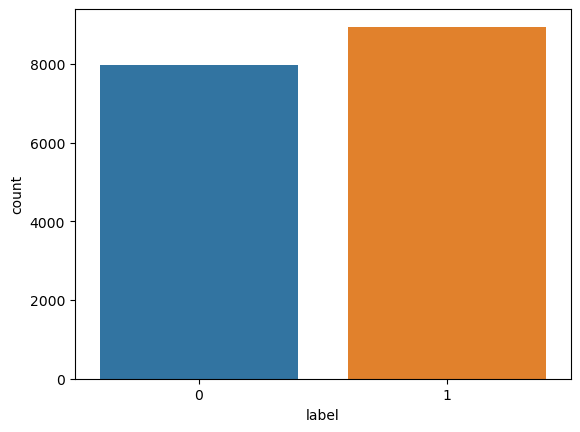

In [64]:
# Visualize the ratio of positive and negative labels in the dataset
# 1 = Postive 0 = Negative

sns.countplot(x = 'label', data = train_tweets)

Data Preprocessing

In [65]:
# removal of punctuation from tweets

def remove_punctuation(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

In [66]:
# tokenize the tweets

def tokenize_tweets(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    temp = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_tokens = ' '.join(temp)
    return clean_tokens

# removing the stop words and returning a clean list of words

def remove_stop_words(tweet):
    temp = tokenize_tweets(tweet)
    no_stop_words = [word for word in temp.split() if word.lower() not in stopwords.words('english')]
    return no_stop_words

In [67]:
# Lemmatizer will break the word down into its root

def lemmatize_tweets(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

In [68]:
#This is a function that will preprocess the tweet all at once

def tweet_scrubber(tweet):
    step1 = remove_punctuation(tweet)
    step2 = tokenize_tweets(step1)
    step3 = remove_stop_words(step2)
    step4 = lemmatize_tweets(step3)

    return step4

# Tweet before and after going through the tweet scrubber
print(test_tweets['tweets'][218])
tweet_scrubber(test_tweets['tweets'][218])

prove it btw hows that tesla stock doing the shorts are having a field day


['prove', 'btw', 'hows', 'tesla', 'stock', 'short', 'field', 'day']

In [69]:
# this will apply the function to scrub the tweets to make sure they are ready to be fed into ML Pipeline

train_tweets['tweet_list'] = train_tweets['tweets'].apply(tweet_scrubber)
test_tweets['tweet_list'] = test_tweets['tweets'].apply(tweet_scrubber)

# example of how the new preprocessed tweet dataframe would look

pd.set_option('display.max_colwidth', 120)
train_tweets[train_tweets['label']==1].drop('tweets',axis=1).head()

,label,tweet_list
0,1,"[FollowFriday, France_Inte, Milipol_Paris, top, engage, members, community, week]"
1,1,"[Hey, James, odd, Please, call, Contact, Centre, able, assist, Many, thank]"
2,1,"[DespiteOfficial, listen, last, night, Bleed, amaze, track, Scotland]"
3,1,[CONGRATS]
4,1,"[yeaaaah, yippppy, accnt, verify, rqst, succeed, get, blue, tick, mark, fb, profile, days]"


ML Algorithm

In [70]:
# creating variables to feed into the sklearn train_test_split function
tweets = train_tweets['tweets']
labels = train_tweets['label']

# after the model is fit, perform predictions using this data
stock_tweet_test = test_tweets['tweets'][:3384]

In [71]:
# creating the 80/20 split
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2)

In [72]:
# Machine Learning Pipeline will take preprocessed data and apply the final vectorization to the data

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer = tweet_scrubber)),  # strings to token integer counts using Bag of Words
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function tweet_scrubber at 0x28e339a20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [73]:
# displaying the accuracy of the model
predictions = pipeline.predict(X_test)
print(predictions)
print(classification_report(predictions,y_test))
print ('\n')
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions, y_test))

[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1472
           1       0.87      0.82      0.84      1912

    accuracy                           0.83      3384
   macro avg       0.83      0.83      0.83      3384
weighted avg       0.83      0.83      0.83      3384



[[1237  235]
 [ 345 1567]]
0.8286052009456265


Prediction on new data

In [84]:
# testing the model on a single example
example = tweet_scrubber("I am so happy that tesla is making a new car")
print(example)
single_prediction = pipeline.predict(example)
print(single_prediction)


['happy', 'tesla', 'make', 'new', 'car']
[1 1 1 1 0]
